# Label Component Unfolding (LCU)

O algoritmo LCU é um sistema dinâmico que pode ser aplicado numa rede complexa para resolver problemas semi-supervisionados. Seu funcionamento espelha-se em comportamentos da natureza e sistemas sociais, como sobrevivência, competição por recursos, exploração territorial e campanhas de eleição.

O autor desse algoritmo é brasileiro, Dr. Filipe Verri (ITA), sendo publicado como um artigo no IEEE e componente da sua tese de doutorado *Collective dynamics in complex networks for machine learning* (2018).

Diferentes de modelos de machine learning mais conhecidos, indutivos, onde há uma etapa prévia de aprendizado e então outra de predição, este algoritmo é classificado **transdutivo**: o aprendizado ocorre de maneira indireta enquanto a predição é feita! Ocorre uma etapa única, iterativa, de classificação.

Nessa camada de resolução do problema, já precisamos ter uma rede complexa formada e uma função de extração de características $ f(X) $, onde $ X $ são os dados de entrada do sistema.

In [24]:
# ref: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut, cat, microaneurysms, rocket, horse, retina, coins
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import networkx as nx

from egsis.complex_networks import complex_network_from_segments
from egsis.complex_networks import draw_complex_network
from egsis.superpixels import build_superpixels_from_image
from egsis.superpixels import superpixel_centroids
from egsis.superpixels import superpixels_max_radius
from egsis import features

# Gerar Superpixels

(-0.5, 450.5, 299.5, -0.5)

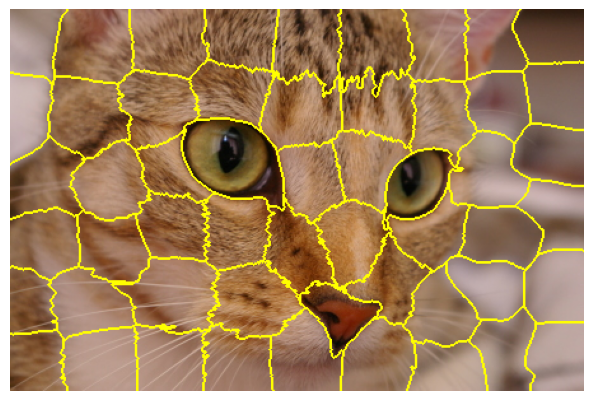

In [26]:
img = img_as_float(cat())
superpixels = build_superpixels_from_image(img, n_segments=50, compactness=40)
ax = plt.imshow(mark_boundaries(img, superpixels))
plt.tight_layout()
plt.axis('off')

# Gerar Rede Complexa

(-29.6125, 450.5, 299.5, -0.5)

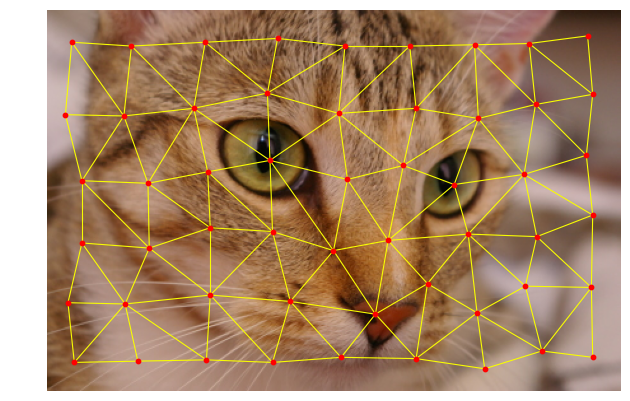

In [19]:
complex_network = complex_network_from_segments(superpixels)
centroids = superpixel_centroids(superpixels)
plt.imshow(img)
draw_complex_network(complex_network, superpixels)
plt.tight_layout()
plt.axis('off')

In [4]:
complex_network.degree[21]

5

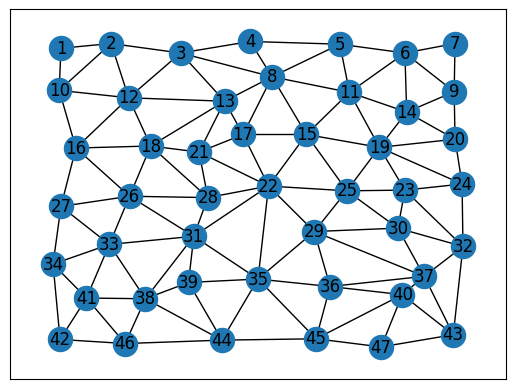

In [16]:
nx.draw_networkx(complex_network, pos=superpixel_centroids(superpixels))
plt.gca().invert_yaxis()
plt.show()

# Extração de Características

A partir desse ponto, será usado uma função de extração de características que transforma um segmento da imagem no domínio da frequência (Fourier), extraindo apenas o valor real e devolve um vetor unidimensional de características.

$$ 
\mathscr{F}(w_1,w_2,\dots,w_m) = \sum_{n_1=-\infty}^\infty \sum_{n_2=-\infty}^\infty \cdots \sum_{n_m=-\infty}^\infty f(n_1,n_2,\dots,n_m) e^{-i w_1 n_1 -i w_2 n_2 \cdots -i w_m n_m} 
$$

Acima está sendo considerado a transformada de fourier multidimensional, não estarei convertendo a imagem em escala cinza para usar a transformada bidimensional pois o espaço vetorial de cor é uma característica importante na segmentação. Nesse caso, a função de extração de características fica, sendo $ X $ a matriz que representa a imagem no espaço RGB:

$$ 
f(\textbf{X}) = \Re{\{\mathscr{F}(\textbf{X})\}} 
$$

Como o problema é pré-clusterizado via superpixel, a extração de características será feito para cada segmento separadamente, desligando os pixels que não fazem parte do segmento em questão e utilizando a função de características $ f $. Cada nó que representa um superpixel na rede complexa, dessa maneira, terá um vetor de características associado.

Como métrica de similaridade, é possível usar similaridade de cosseno ou similaridade euclidiana. A partir dos vetores de caractéristas $ \vec{x_1} $ e $ \vec{x_2} $, usa-se as seguintes funções que possuem domínio em $ [0, 1] $:

$$ 
s_{euc}(\vec{x_1}, \vec{x_2}) = \dfrac{1}{1+\sqrt{(\vec{x_1} - \vec{x_2})^2}}
$$

$$ 
s_{cos}(\vec{x_1}, \vec{x_2}) = \dfrac{\vec{x_1} \cdot \vec{x_2}}{\lVert \vec{x_1} \rVert \cdot \lVert \vec{x_2} \rVert}
$$

Max superpixel radius: 40


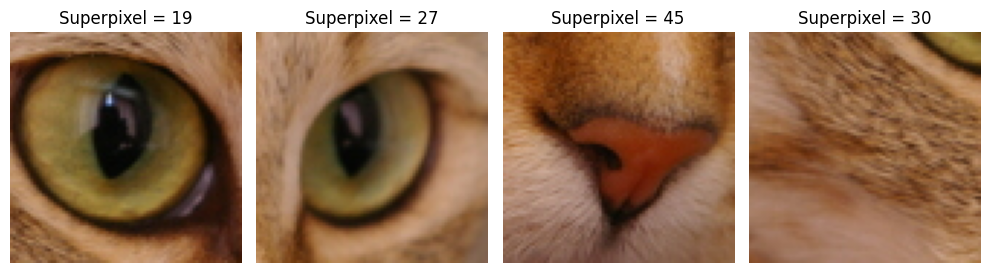

In [20]:
max_radius = superpixels_max_radius(superpixels, centroids)
print(f"Max superpixel radius: {max_radius}")
def plot_superpixel(ax, superpixel):
    segment = features.get_segment_by_label_cropped(
        img,
        superpixels,
        superpixel,
        max_radius=max_radius,
        centroid=centroids[superpixel],
        erase_color=255
    )
    ax.set_title(f"Superpixel = {superpixel}")
    ax.imshow(segment)
    
selected_superpixels = [19, 27, 45, 30]


fig, ax = plt.subplots(1, len(selected_superpixels), figsize=(10, 10), sharex=True, sharey=True)
for idx, superpixel in enumerate(selected_superpixels):    
    plot_superpixel(ax[idx], superpixel)



for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [21]:
# Build similarity matrix
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray

img_segments = [
    features.get_segment_by_label_cropped(
        img, 
        superpixels, 
        selected_superpixels[i],
        max_radius=max_radius,
        centroid=centroids[selected_superpixels[i]],
        erase_color=0
    )
    for i in range(len(selected_superpixels))
]
vectors = [features.feature_extraction(x) for x in img_segments]
# vectors = img_segments
n_vectors = len(vectors)
similarity_matrix = np.zeros(shape=(n_vectors, n_vectors))
similarity_matrix 

for i in range(n_vectors):
    for j in range(n_vectors):
        if i == j:
            continue
        similarity_matrix[i, j] = features.euclidian_similarity(vectors[i], vectors[j])

        
similarity_matrix = np.around(similarity_matrix, decimals=10)
similarity_matrix

array([[0.        , 0.0002322 , 0.00022692, 0.00023709],
       [0.0002322 , 0.        , 0.00027174, 0.0002918 ],
       [0.00022692, 0.00027174, 0.        , 0.00029203],
       [0.00023709, 0.0002918 , 0.00029203, 0.        ]])

In [22]:
img_segments[0].shape

(80, 80, 3)

Text(0.5, 1.0, 'Similarity Matrix over feature space')

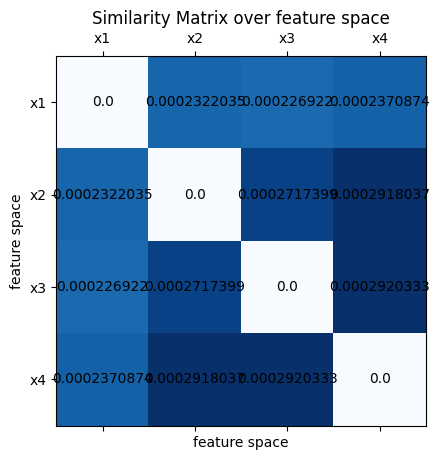

In [23]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.matshow(similarity_matrix, cmap=plt.cm.Blues)

for i in range(n_vectors):
    for j in range(n_vectors):
        c = similarity_matrix[i, j]
        ax.text(i, j, str(c), va='center', ha='center')
        
axis_labels =[f"x{k+1}" for k in range(len(selected_superpixels))]
axis_range = range(len(axis_labels))
plt.xticks(axis_range, axis_labels)
plt.yticks(axis_range, axis_labels)
plt.xlabel("feature space")
plt.ylabel("feature space")
plt.title("Similarity Matrix over feature space")

In [10]:
vectors[3]

array([-0.38823529-1.35847122e-01j,  1.27058824+1.11022302e-16j,
       -0.38823529+1.35847122e-01j, ...,  0.3225441 +1.05131428e-02j,
        1.99980821+1.12469102e+00j,  0.1683916 -1.13067282e-01j])

In [11]:
vectors[2]

array([-0.08039216+5.33199954e-01j,  1.05490196+4.44089210e-16j,
       -0.08039216-5.33199954e-01j, ...,  0.28094554-1.29465293e-01j,
       -1.20054156+1.58266604e+00j,  0.02097821-1.35304763e-02j])